# **Final Project**
# Face Mask Detection

### Group: Adam 10
### Authors: Kamila Makhambetova(kamilam3), Niharika Chintalapi (nchint4), Wang Weiyang (weiyang7)

<br>

## <font color='red'> Don't run these sections 1,2,3,4,5 as it is data extraction and model training, based on dataset.</font> 




## <font color='red'> Run section 6, the final program.</font> 

<br>

In [2]:
import os

# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: /Users/kamila/Desktop


In [3]:
os.chdir('/Users/kamila/Desktop')

## 1. Data extraction

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import pathlib

data_set_dir = "/Users/kamila/Desktop/dataset2"

transform = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.ImageFolder(data_set_dir, transform=transform)

In [5]:
from torch.utils.data import DataLoader,random_split

# Determine number observations
m = len(dataset)
p=0.4

# Split the train data set into a train and dev data set.
train_dataset, test_dataset = random_split(dataset, [int(m - m*p), m-int(m - m*p)])

In [6]:
#categories
root=pathlib.Path(data_set_dir)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

classes

['.DS_Store',
 'not wearing mask',
 'wearing mask improperly',
 'wearing mask properly']

In [7]:
classes2=classes[1:4]
classes2

['not wearing mask', 'wearing mask improperly', 'wearing mask properly']

In [8]:
img,label=train_dataset[100]
print(img.shape, label)

torch.Size([3, 227, 227]) 0


## 2. CNN (AlexNet)

In [13]:

class AlexNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(96, 256, kernel_size=5, stride= 1, padding= 2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(256, 384, kernel_size=3,stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 384, kernel_size=3,stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classify = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        prediction = self.classify(x)
        return prediction

## 3. Training model

In [10]:
AlexNet = AlexNet()
print(AlexNet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classify): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

In [15]:
#Model training, validation and saving best model

import torch
from torch import nn, optim


def train_test_model(batch_size, epochs, lr, AlexNet,optimizer, location):
    
    
    # Setup loaders
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, 
                                          shuffle = True)
    
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    
    
    # Set Loss function with criterion
    criterion = nn.CrossEntropyLoss()
    
    
    # Set optimizer with optimizer
    
    optimizer=optimizer
    
    total_step = len(train_loader)
    AlexNet=AlexNet.to(device=device)
    
    best_accuracy=0.0
    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    for epoch in range(epochs):
        
        #Evaluation and training on training dataset
        AlexNet.train()
        train_accuracy=0.0
        train_loss=0.0
        
        
        for i, (images,labels) in enumerate(train_loader):
            
            images=images.to(device=device)
            labels=labels.to(device=device)
            
            optimizer.zero_grad()
            outputs=AlexNet(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)
            train_accuracy+=int(torch.sum(prediction==labels.data))
        
        
        train_accuracies.append(train_accuracy/len(train_dataset))
        train_losses.append(train_loss/len(train_dataset))
        train_accuracy=train_accuracy/len(train_dataset)
        train_loss=train_loss/len(train_dataset)
    
    
        # Evaluation on testing dataset
        AlexNet.eval()
    
        test_accuracy=0.0
        test_loss=0.0
        
        with torch.no_grad():
            for i, (images,labels) in enumerate(test_loader):
                
                images=images.to(device=device)
                labels=labels.to(device=device)
                
                outputs=AlexNet(images)
                loss= criterion(outputs, labels)
                test_loss+= loss.cpu().data*images.size(0)
            
                _,prediction=torch.max(outputs.data,1)
                test_accuracy+=int(torch.sum(prediction==labels.data))
    
        test_accuracies.append(test_accuracy/len(test_dataset))
        test_losses.append(test_loss/len(test_dataset))
        test_accuracy=test_accuracy/len(test_dataset)
        test_loss=test_loss/len(test_dataset)
        
    
        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
        #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(AlexNet.state_dict(), location)
            best_accuracy=test_accuracy
    
    vect_epochs=range(1, epochs+1)
    plt.plot(vect_epochs, train_losses, label='Training loss')
    plt.plot(vect_epochs, test_losses, label='Testing loss')
    plt.plot(vect_epochs, train_accuracies, label='Training accuracies')
    plt.plot(vect_epochs, test_accuracies, label='Testing accuracies')
    plt.xlabel("epochs")
    plt.legend(frameon=False)
    plt.show()

## 4. Generate 3 different models

Epoch: 0 Train Loss: tensor(2.4413) Train Accuracy: 0.3974287311347121 Test Accuracy: 0.4204355108877722
Epoch: 1 Train Loss: tensor(1.0528) Train Accuracy: 0.41475684740078256 Test Accuracy: 0.40033500837520936
Epoch: 2 Train Loss: tensor(0.9130) Train Accuracy: 0.5824482951369481 Test Accuracy: 0.7261306532663316
Epoch: 3 Train Loss: tensor(0.5247) Train Accuracy: 0.7786472889882616 Test Accuracy: 0.8031825795644891
Epoch: 4 Train Loss: tensor(0.4616) Train Accuracy: 0.8082727780883175 Test Accuracy: 0.8634840871021775
Epoch: 5 Train Loss: tensor(0.3171) Train Accuracy: 0.8820570150922303 Test Accuracy: 0.9212730318257957
Epoch: 6 Train Loss: tensor(0.2366) Train Accuracy: 0.9217439910564561 Test Accuracy: 0.9606365159128978
Epoch: 7 Train Loss: tensor(0.1634) Train Accuracy: 0.946338736724427 Test Accuracy: 0.9681742043551089
Epoch: 8 Train Loss: tensor(0.1339) Train Accuracy: 0.9636668529904975 Test Accuracy: 0.9673366834170855
Epoch: 9 Train Loss: tensor(0.0998) Train Accuracy: 0.

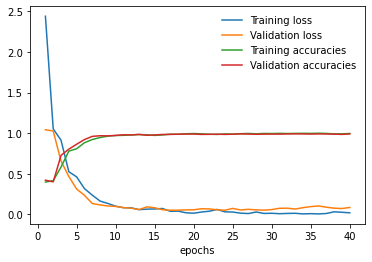

In [9]:
optimizer=optim.Adam(AlexNet.parameters(), lr= 0.001)
location='/Users/kamila/Desktop/models/a1'

train_test_model(200, 40, 0.001, AlexNet, optimizer, location)

Epoch: 0 Train Loss: tensor(0.0185) Train Accuracy: 0.9927333705980995 Test Accuracy: 0.990787269681742
Epoch: 1 Train Loss: tensor(0.0208) Train Accuracy: 0.9927333705980995 Test Accuracy: 0.990787269681742
Epoch: 2 Train Loss: tensor(0.0196) Train Accuracy: 0.9938513135830073 Test Accuracy: 0.990787269681742
Epoch: 3 Train Loss: tensor(0.0200) Train Accuracy: 0.9916154276131918 Test Accuracy: 0.990787269681742
Epoch: 4 Train Loss: tensor(0.0244) Train Accuracy: 0.9910564561207379 Test Accuracy: 0.990787269681742
Epoch: 5 Train Loss: tensor(0.0092) Train Accuracy: 0.9960871995528228 Test Accuracy: 0.990787269681742
Epoch: 6 Train Loss: tensor(0.0150) Train Accuracy: 0.9960871995528228 Test Accuracy: 0.990787269681742
Epoch: 7 Train Loss: tensor(0.0140) Train Accuracy: 0.9960871995528228 Test Accuracy: 0.990787269681742
Epoch: 8 Train Loss: tensor(0.0136) Train Accuracy: 0.9944102850754611 Test Accuracy: 0.990787269681742
Epoch: 9 Train Loss: tensor(0.0081) Train Accuracy: 0.9977641140

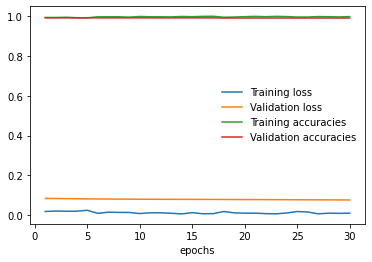

In [10]:
optimizer=torch.optim.SGD(AlexNet.parameters(), lr=0.0001, weight_decay = 0.005, momentum = 0.9)

location='/Users/kamila/Desktop/models/a2'

train_test_model(300, 30, 0.0001, AlexNet, optimizer, location)

Epoch: 0 Train Loss: tensor(1.7304) Train Accuracy: 0.41320022185246813 Test Accuracy: 0.49168053244592347
Epoch: 1 Train Loss: tensor(0.8367) Train Accuracy: 0.6932889628397116 Test Accuracy: 0.7653910149750416
Epoch: 2 Train Loss: tensor(0.5155) Train Accuracy: 0.812534664448142 Test Accuracy: 0.8219633943427621
Epoch: 3 Train Loss: tensor(0.3851) Train Accuracy: 0.8275097060454798 Test Accuracy: 0.8286189683860233
Epoch: 4 Train Loss: tensor(0.2447) Train Accuracy: 0.9195784803105934 Test Accuracy: 0.9525790349417638
Epoch: 5 Train Loss: tensor(0.1678) Train Accuracy: 0.9506378258458126 Test Accuracy: 0.9217970049916805
Epoch: 6 Train Loss: tensor(0.1788) Train Accuracy: 0.9362174154187465 Test Accuracy: 0.9600665557404326
Epoch: 7 Train Loss: tensor(0.1074) Train Accuracy: 0.963948973932335 Test Accuracy: 0.9700499168053245
Epoch: 8 Train Loss: tensor(0.0887) Train Accuracy: 0.9733777038269551 Test Accuracy: 0.9758735440931781
Epoch: 9 Train Loss: tensor(0.0769) Train Accuracy: 0.9

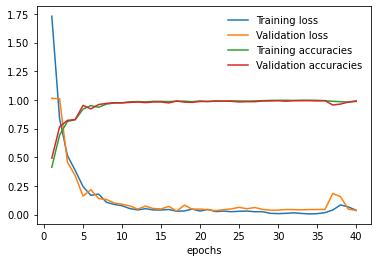

In [16]:
optimizer=optim.Adam(AlexNet.parameters(), lr= 0.001)

location='/Users/kamila/Desktop/models/a3'

train_test_model(180, 40, 0.001, AlexNet, optimizer, location)

## 5. Face detection

In [11]:
!pip3 install detecto

In [14]:
from os import listdir
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from detecto.utils import read_image


AlexNet=AlexNet()
AlexNet.load_state_dict(torch.load("/Users/kamila/Desktop/models/a1"))

def predict_image(image, AlexNet):
    to_pil = transforms.ToPILImage()
    image = to_pil(image)
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    #input = input.to(device)
    output = AlexNet(input)
    index = output.data.cpu().numpy().argmax()
    return index

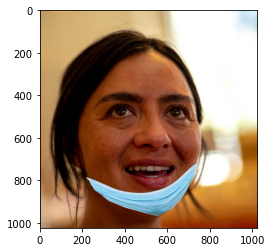

wearing mask improperly 1


In [15]:

image_dir='/Users/kamila/Desktop/dataset2/wearing mask improperly/00017_Mask_Chin.jpg'
image=read_image(image_dir)
image_output=predict_image(image, AlexNet)
plt.imshow(image)
plt.show()
print(classes2[image_output], image_output)

In [16]:
!pip install facenet-pytorch 

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


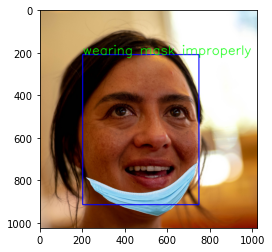

wearing mask improperly 1


In [17]:
import cv2
from facenet_pytorch import MTCNN
from PIL import Image

mtcnn=MTCNN(image_size=227, margin=0, keep_all=True, min_face_size=40) #keep multiple faces

# draw the bounding boxes for face detection
def draw_bbox(bounding_boxes, image):
    
    for i in range(len(bounding_boxes)):
        x1, y1, x2, y2 = bounding_boxes[i]
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)),
                     (0, 0, 255), 3)
        image_output=predict_image(image, AlexNet)
        caption=classes2[image_output]
    cv2.putText(image, caption, (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2, cv2.LINE_AA)
        
    return image

boxes, probability= mtcnn.detect(image, landmarks=False)
image1=draw_bbox(boxes, image)
plt.imshow(image1)
plt.show()
print(classes2[predict_image(image1, AlexNet)], predict_image(image1, AlexNet))

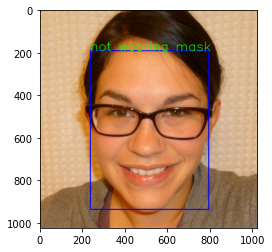

not wearing mask 0


In [18]:
image_dir2='/Users/kamila/Desktop/dataset2/not wearing mask/00037.png'
image2=read_image(image_dir2)

boxes, probability= mtcnn.detect(image2, landmarks=False)
image2=draw_bbox(boxes, image2)
plt.imshow(image2)
plt.show()
print(classes2[predict_image(image2, AlexNet)], predict_image(image2, AlexNet))

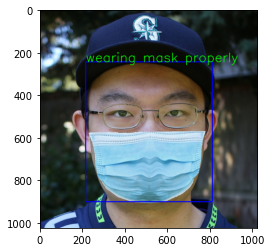

wearing mask properly 2


In [19]:
image_dir3='/Users/kamila/Desktop/dataset2/wearing mask properly/01660_Mask.jpg'
image3=read_image(image_dir3)

boxes, probability= mtcnn.detect(image3, landmarks=False)
image3=draw_bbox(boxes, image3)
plt.imshow(image3)
plt.show()
print(classes2[predict_image(image3, AlexNet)], predict_image(image3, AlexNet))

## 6. Real time face mask detection (Our final program)

<br>

## <font color='red'> NOTE: </font> 

### <font color='blue'> If your laptop webcam don't open, try to input different number into cv2.VideoCapture( ). For Mac Pro I used cv2.VideoCapture(0). Also don't forget to change directory to pre-trained AlexNet model in predict_image2 function </font> 

<br>

In [6]:
!pip3 install detecto
!pip install facenet-pytorch 

from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import pathlib
import os

In [7]:
from torch.autograd import Variable
import cv2
from facenet_pytorch import MTCNN
from PIL import Image


class AlexNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(96, 256, kernel_size=5, stride= 1, padding= 2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(256, 384, kernel_size=3,stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 384, kernel_size=3,stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classify = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        prediction = self.classify(x)
        #return prediction
        return torch.sigmoid(prediction)



def draw(bounding_boxes, probs, image):
    
    for box, prob in zip(bounding_boxes, probs):
        
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(0, 0, 255), 2)
        
        #Extract the face data, convert it to tensor
        
        rgb_frame=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        face_frame=rgb_frame[(int(box[1])):(int(box[1])+int(box[3])), (int(box[0])):(int(box[0])+int(box[2])),:]
        classes2=['not wearing mask', 'wearing mask improperly', 'wearing mask properly']
        prob, pred =torch.max(predict_image2(face_frame).data,dim=1)
        caption=classes2[pred]
        
        cv2.putText(image, str("{:.3f}".format(prob.item())), (int(box[0]), int(box[3]+25)), cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),1, cv2.LINE_AA)
        cv2.putText(image, caption, (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),1, cv2.LINE_AA)
        
    return image



def predict_image2(image):
    alexnet=AlexNet()
    alexnet.load_state_dict(torch.load("/Users/kamila/Desktop/final project (Deep Learning) 2/the_best_model"))
    to_pil = transforms.ToPILImage()
    image = to_pil(image)
    transform = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    #input = input.to(device)
    output = alexnet(input)

    return output

In [8]:
os.chdir('/Users/kamila/Desktop')

import cv2
from facenet_pytorch import MTCNN
from PIL import Image

mtcnn=MTCNN(image_size=100, margin=0, keep_all=True, min_face_size=70) #keep multiple face

#write name of video inside VideoCapture
#cap=cv2.VideoCapture('test.mov')

cap=cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame=cap.read()
    boxes, probability= mtcnn.detect(frame, landmarks=False)
    #print(boxes)
    if(boxes is not None and probability.any()>0.95):
        draw(boxes, probability, frame)
    
    cv2.imshow('Face detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

## Gradio on our trained model (Classification problem)

In [4]:
!pip install gradio

In [5]:
import gradio as gr


def predict_image_class(image):
    alexnet=AlexNet()
    alexnet.load_state_dict(torch.load("/Users/kamila/Desktop/models/a1"))
    to_pil = transforms.ToPILImage()
    image = to_pil(image)
    transform = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    output = alexnet(input)
    prob, pred =torch.max(output.data,dim=1)
    classes2=['not wearing mask', 'wearing mask improperly', 'wearing mask properly']
    caption=classes2[pred]
    return caption


iface=gr.Interface(fn=predict_image_class, inputs=gr.inputs.Image(),outputs="label")

iface.launch()



Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<fastapi.applications.FastAPI at 0x7ff324b82a00>,
 'http://127.0.0.1:7860/',
 None)

## Reference section

References:

1. 12a-pytorch-cnn-mnist.ipynb, Professor James Balamuta Google Collab code, from https://colab.research.google.com/github/fdluiuc/lecture-notebooks/blob/master/12a-cnn-pytorch-mnist.ipynb

2. Introduction to The Architecture of Alexnet, shipra_saxena, 19 March 2021, from https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/

3. How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images, Chris Fotache, 20 November 2018, from https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

4. Automatic Face and Facial Landmark Detection with Facenet PyTorch, Sovit Ranjan Rath, 9 Nov 2020, from https://debuggercafe.com/automatic-face-and-facial-landmark-detection-with-facenet-pytorch/